In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sympy import symbols, Eq, solve
from datetime import datetime
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Creating Dataframe

We are just builidng our original dataframe here with date, price, interest, and price changes

In [131]:
excel_file_path = 'chapt26.xlsx'
interest = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,H')
interest = interest.iloc[7:]
interest.columns = ['Year', 'Interest']
interest = interest.reset_index(drop=True)

In [132]:
excel_file_path = 'monthly_data.xls'
df = pd.read_excel(excel_file_path, sheet_name='Data', usecols='A,J')
df = df.iloc[7:]
df = df.reset_index(drop=True)
df.columns = ['Date', 'Price']

def correct_date_string_specific(date_str):
    parts = str(date_str).split('.')
    if len(parts) == 2 and parts[1] == '1':
        parts[1] = '10'
    return '.'.join(parts)

df['Date'] = df['Date'].apply(correct_date_string_specific)
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m')
df['Year'] = df['Date'].dt.year

In [133]:
df = pd.merge(interest, df, on = "Year")
df["Interest"] = (df["Interest"] - 1)/12
df = df[["Date", "Price", "Interest"]]

def add_percent_change (df):
    df = df.copy()
    diff = df['Price'].pct_change(fill_method=None)
    df["Percent Change"] = diff
    return df

df = add_percent_change(df)
df.head()

,Date,Price,Interest,Percent Change
0,1871-01-01,109.050018,0.003959,NaN
1,1871-02-01,107.765291,0.003959,-0.011781
2,1871-03-01,109.298845,0.003959,0.01423
3,1871-04-01,117.171191,0.003959,0.072026
4,1871-05-01,123.479273,0.003959,0.053836


# DataFrame Functions

In [134]:
def filter_dataframe_by_date (df, start_date=datetime(1500, 1, 1), end_date=datetime(9999, 1, 1)):
    
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    filtered_df.head()

    return filtered_df.reset_index(drop=True)

def compare_growth_of_diff_leverages (df, start_amount, contributions=5000):
    df.loc[0, "Total Normal Amount"] = start_amount
    df.loc[0, "Total 3x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2.5x Leveraged Amount"] = start_amount
    df.loc[0, "Total 2x Leveraged Amount"] = start_amount
    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions
        df.loc[i, 'Total 3x Leveraged Amount'] = df.loc[i - 1, 'Total 3x Leveraged Amount'] * (1 + ((3 * percent_change) - (2 * interest_change))) + contributions
        df.loc[i, 'Total 2.5x Leveraged Amount'] = df.loc[i - 1, 'Total 2.5x Leveraged Amount'] * (1 + ((2.5 * percent_change) - (1.5 * interest_change))) + contributions
        df.loc[i, 'Total 2x Leveraged Amount'] = df.loc[i - 1, 'Total 2x Leveraged Amount'] * (1 + ((2 * percent_change) - (1 * interest_change))) + contributions
    return df


# Math Functions

In [136]:

def market_drop(leveraged_x, new_leveraged_x):
    amount = 10000.
    leveraged_amount = amount * leveraged_x

    x = symbols('x')
    equation = Eq((leveraged_amount - x) / (amount - x), new_leveraged_x)
    total_amount_drop = solve(equation, x)[0]
    return total_amount_drop / amount


def calculate_diff_leverages_growth(df, month_interval=6, startamount=10000, contributions=5000):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1901, 1, 1)

    normal_end_amounts = []
    leveraged3x_end_amounts = []
    leveraged25x_end_amounts = []
    leveraged2x_end_amounts = []
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df = compare_growth_of_diff_leverages(new_df, startamount, contributions)

        normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
        leveraged3x_end_amount = new_df["Total 3x Leveraged Amount"].iloc[-1]
        leveraged25x_end_amount = new_df["Total 2.5x Leveraged Amount"].iloc[-1]
        leveraged2x_end_amount = new_df["Total 2x Leveraged Amount"].iloc[-1]

        normal_end_amounts.append(normal_end_amount)
        leveraged3x_end_amounts.append(leveraged3x_end_amount)
        leveraged25x_end_amounts.append(leveraged25x_end_amount)
        leveraged2x_end_amounts.append(leveraged2x_end_amount)


        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return normal_end_amounts, leveraged3x_end_amounts, leveraged25x_end_amounts, leveraged2x_end_amounts
    

In [137]:
price_diff = filter_dataframe_by_date(df, datetime(1871, 2, 1), datetime(1901, 2, 1))
price_diff = compare_growth_of_diff_leverages(price_diff, 10000.)
price_diff.tail()

,Date,Price,Interest,Percent Change,Total Normal Amount,Total 3x Leveraged Amount,Total 2.5x Leveraged Amount,Total 2x Leveraged Amount
356,1900-10-01,1108.106193,0.00602,0.053145,6.416609e+06,4.817862e+06,5.556760e+06,6.130041e+06
357,1900-11-01,1199.257608,0.00602,0.082259,6.949432e+06,5.953791e+06,6.654314e+06,7.106638e+06
358,1900-12-01,1292.011908,0.00602,0.077343,7.491922e+06,7.268563e+06,7.885890e+06,8.168156e+06
359,1901-01-01,1317.880649,0.001489,0.020022,7.646926e+06,7.688514e+06,8.268008e+06,8.488081e+06
360,1901-02-01,1373.095838,0.001489,0.041897,7.972309e+06,8.636995e+06,9.120553e+06,9.191693e+06


In [138]:
normal_list, leverage3x_list, leverage25x_list, leverage2x_list  = calculate_diff_leverages_growth(df, 6, 10000)

2024-01-01 00:00:00


In [139]:
s_normal = pd.Series(normal_list)
s_leverage3x = pd.Series(leverage3x_list)
s_leverage25x = pd.Series(leverage25x_list)
s_leverage2x = pd.Series(leverage2x_list)
print(s_normal.describe())
print(s_leverage3x.describe())

count    2.460000e+02
mean     6.225314e+06
std      2.532466e+06
min      2.148054e+06
25%      4.511719e+06
50%      5.603167e+06
75%      7.656455e+06
max      1.286377e+07
dtype: float64
count    2.460000e+02
mean     6.460521e+07
std      1.316473e+08
min      9.522378e+04
25%      3.886074e+06
50%      1.028625e+07
75%      3.678934e+07
max      6.409034e+08
dtype: float64


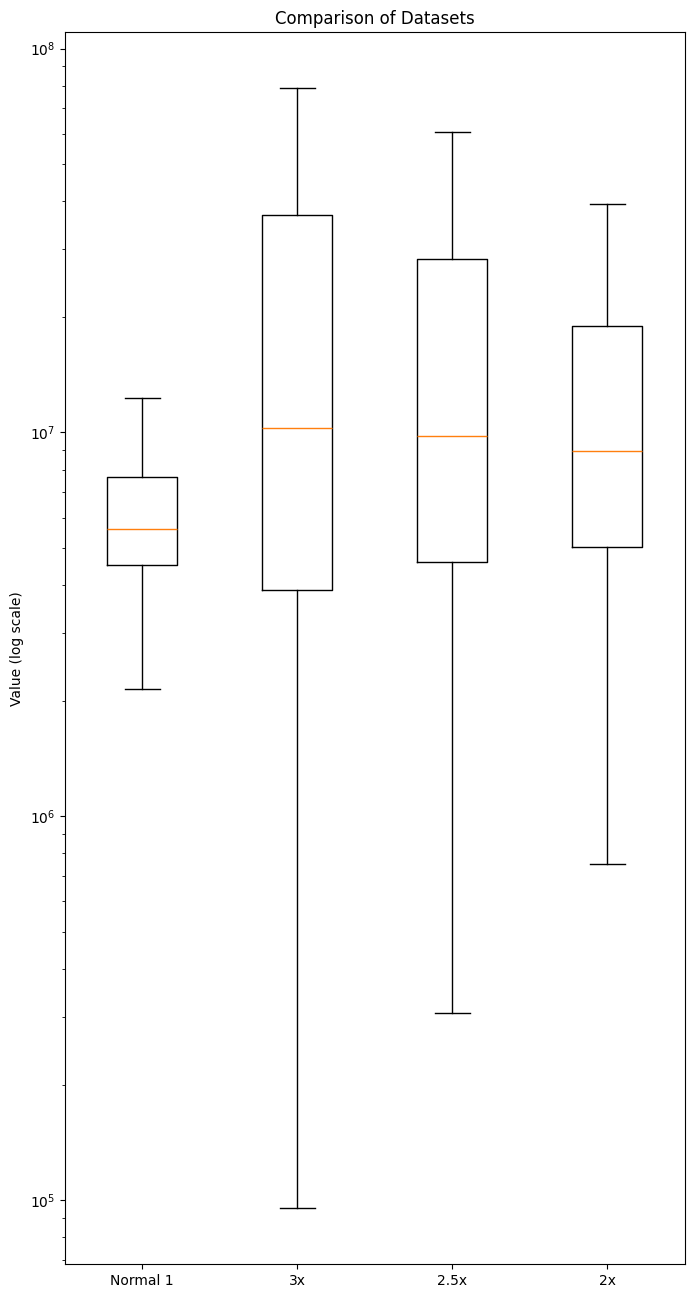

In [140]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 16))
plt.boxplot([s_normal, s_leverage3x, s_leverage25x, s_leverage2x], positions=[1, 2, 3, 4], showfliers=False)
plt.yscale('log')  # Using a logarithmic scale
plt.xticks([1, 2, 3, 4], ['Normal 1', '3x', '2.5x', '2x'])
plt.title('Comparison of Datasets')
plt.ylabel('Value (log scale)')
plt.show()

In [ ]:
def calculate_growth_with_glide_path (df, start_amount, contributions=5000):
    df.loc[0, "Total Normal Amount"] = start_amount
    df.loc[0, "Total Leveraged Amount"] = start_amount

    for i in range(1, len(df)):
        percent_change = df.loc[i, "Percent Change"]
        interest_change  = df.loc[i, "Interest"]
        prev_amount = df.loc[i - 1, 'Total Leveraged Amount']
        glide_path = calc_glide_path(prev_amount)
        df.loc[i, 'Total Normal Amount'] = df.loc[i - 1, 'Total Normal Amount'] * (1 + percent_change) + contributions
        df.loc[i, 'Total Leveraged Amount'] = prev_amount * (1 + ((glide_path * percent_change) - ((glide_path - 1) * interest_change))) + contributions
    return df

def calc_glide_path (amount):
    if (amount < 1000000):
        return 3 - amount/1000000
    if (amount > 1000000 and amount < 6000000):
        return 2 - (amount - 1000000) / 5000000
    return 1

def calculate_30_year_end_amount_with_glide_path(df, month_interval=6, startamount=10000, contributions=5000):
    start_date = datetime(1871, 1, 1)
    end_date = datetime(1901, 1, 1)

    normal_end_amounts = []
    leveraged_end_amounts = []
    while end_date < datetime(2024, 1, 1):
        new_df = filter_dataframe_by_date(df, start_date, end_date)
        new_df = calculate_growth_with_glide_path(new_df, startamount, contributions)

        normal_end_amount = new_df["Total Normal Amount"].iloc[-1]
        leveraged_end_amount = new_df["Total Leveraged Amount"].iloc[-1]

        normal_end_amounts.append(normal_end_amount)
        leveraged_end_amounts.append(leveraged_end_amount)


        start_date += relativedelta(months=month_interval)
        end_date += relativedelta(months=month_interval)

    print(end_date)
    return normal_end_amounts, leveraged_end_amounts
    
    

# Graph of our Glide Path Function

We our upper bounding at 3 here but can experiment with different values

In [ ]:
# Create an array of 'amount' values over which to evaluate the function
amounts = np.linspace(0, 10000000, 500)  # From 0 to 10,000,000

# Calculate the glide path values for each amount
glide_path_values = [calc_glide_path(amount) for amount in amounts]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(amounts, glide_path_values, label='Glide Path')
plt.title('Glide Path Function Graph')
plt.xlabel('Amount')
plt.ylabel('Glide Path Value')
plt.grid(True)
plt.show()

In [141]:
normal_list, leverage_list = calculate_30_year_end_amount_with_glide_path(df)

2024-01-01 00:00:00


In [142]:
s_normal = pd.Series(normal_list)
s_leverage = pd.Series(leverage_list)
print(s_normal.describe())
print(s_leverage.describe())

count    2.460000e+02
mean     6.225314e+06
std      2.532466e+06
min      2.148054e+06
25%      4.511719e+06
50%      5.603167e+06
75%      7.656455e+06
max      1.286377e+07
dtype: float64
count    2.460000e+02
mean     1.006976e+07
std      5.681770e+06
min      2.316668e+06
25%      6.200627e+06
50%      8.554968e+06
75%      1.178650e+07
max      2.631339e+07
dtype: float64


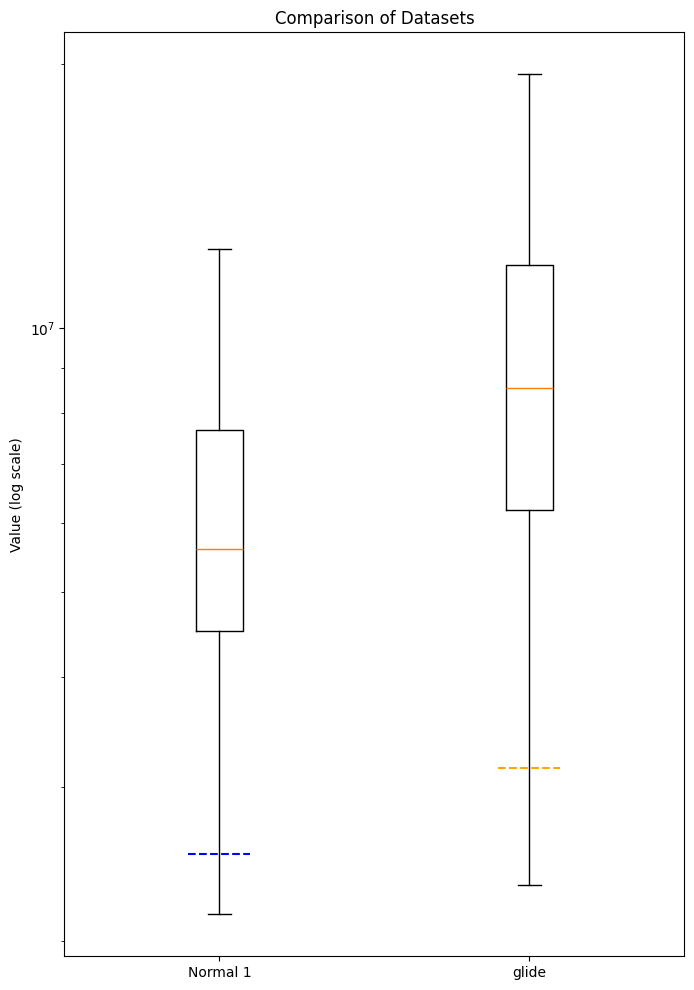

In [143]:
# Plotting side-by-side boxplots
plt.figure(figsize=(8, 12))
plt.boxplot([s_normal, s_leverage], positions=[1, 2], showfliers=False)

# Calculate the 10th percentile for each dataset
percentile_10_data1 = np.percentile(s_normal, 2)
percentile_10_data2 = np.percentile(s_leverage, 2)

plt.hlines(percentile_10_data1, 0.9, 1.1, colors='blue', linestyles='dashed', label='10th Percentile Data1')
plt.hlines(percentile_10_data2, 1.9, 2.1, colors='orange', linestyles='dashed', label='10th Percentile Data2')
plt.yscale('log')  # Using a logarithmic scale
plt.xticks([1, 2], ['Normal 1', 'glide'])
plt.title('Comparison of Datasets')
plt.ylabel('Value (log scale)')
plt.show()